# Edact Ray Baseline On Scans

This notebook contains the code for the Edact Ray baseline that has been adapted to work for documents that are scanned by using OCR to obtain information on the location of characters and spaces. The notebook includes the evaluation of the algorithm on the test set. The original algorithm is described [here](https://scholar.google.com/scholar?hl=nl&as_sdt=0%2C5&q=Story+Beyond+the+Eye%3A+Glyph+Positions+Break+PDF+Text+Redaction&btnG=).

## Index

1. [Introduction](#intro)
2. [Analysing Tesseract](#tesseract)
3. [Inline Redactions](#inline_redactions)
4. [Multiline Redactions](#multiline_redactions)
5. [Model Evaluation](#evaluation)

In [4]:
# Imports
import os
import cv2
import json
import time
import platform
import pytesseract
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# Disable copy warnings from pandas
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

# import local files
from utils import *
from evaluation import *

In [5]:
def show_image(image: np.ndarray) -> None:
    """
    Function that shows in amge loaded with cv2 in matplotlib, and
    converts it from the BGR color fromat to the RGB color format.
    :image: a numpy array of size (H, W, 3) that contains the image.
    """
    plt.figure(figsize=(20, 20))
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

<a id="intro"><h2>Introduction</h2></a>

We will start some examples of redactions in pages, and build the algorithm with the inline- and multiline detection methods as we go along.

In [6]:
# Load some
test_image_1 = load_image(os.path.join('../resources/dataset/test/images', 'Wob-besluit-Project-No-Waste-2021-011855__concatenated-page-006.png'))
test_image_2 = load_image(os.path.join('../resources/dataset/train/images', '20180321_bijlage_1_bij_agenda_stuurgroep_conceptverslag_stuurgroep_13122017-3.png'))

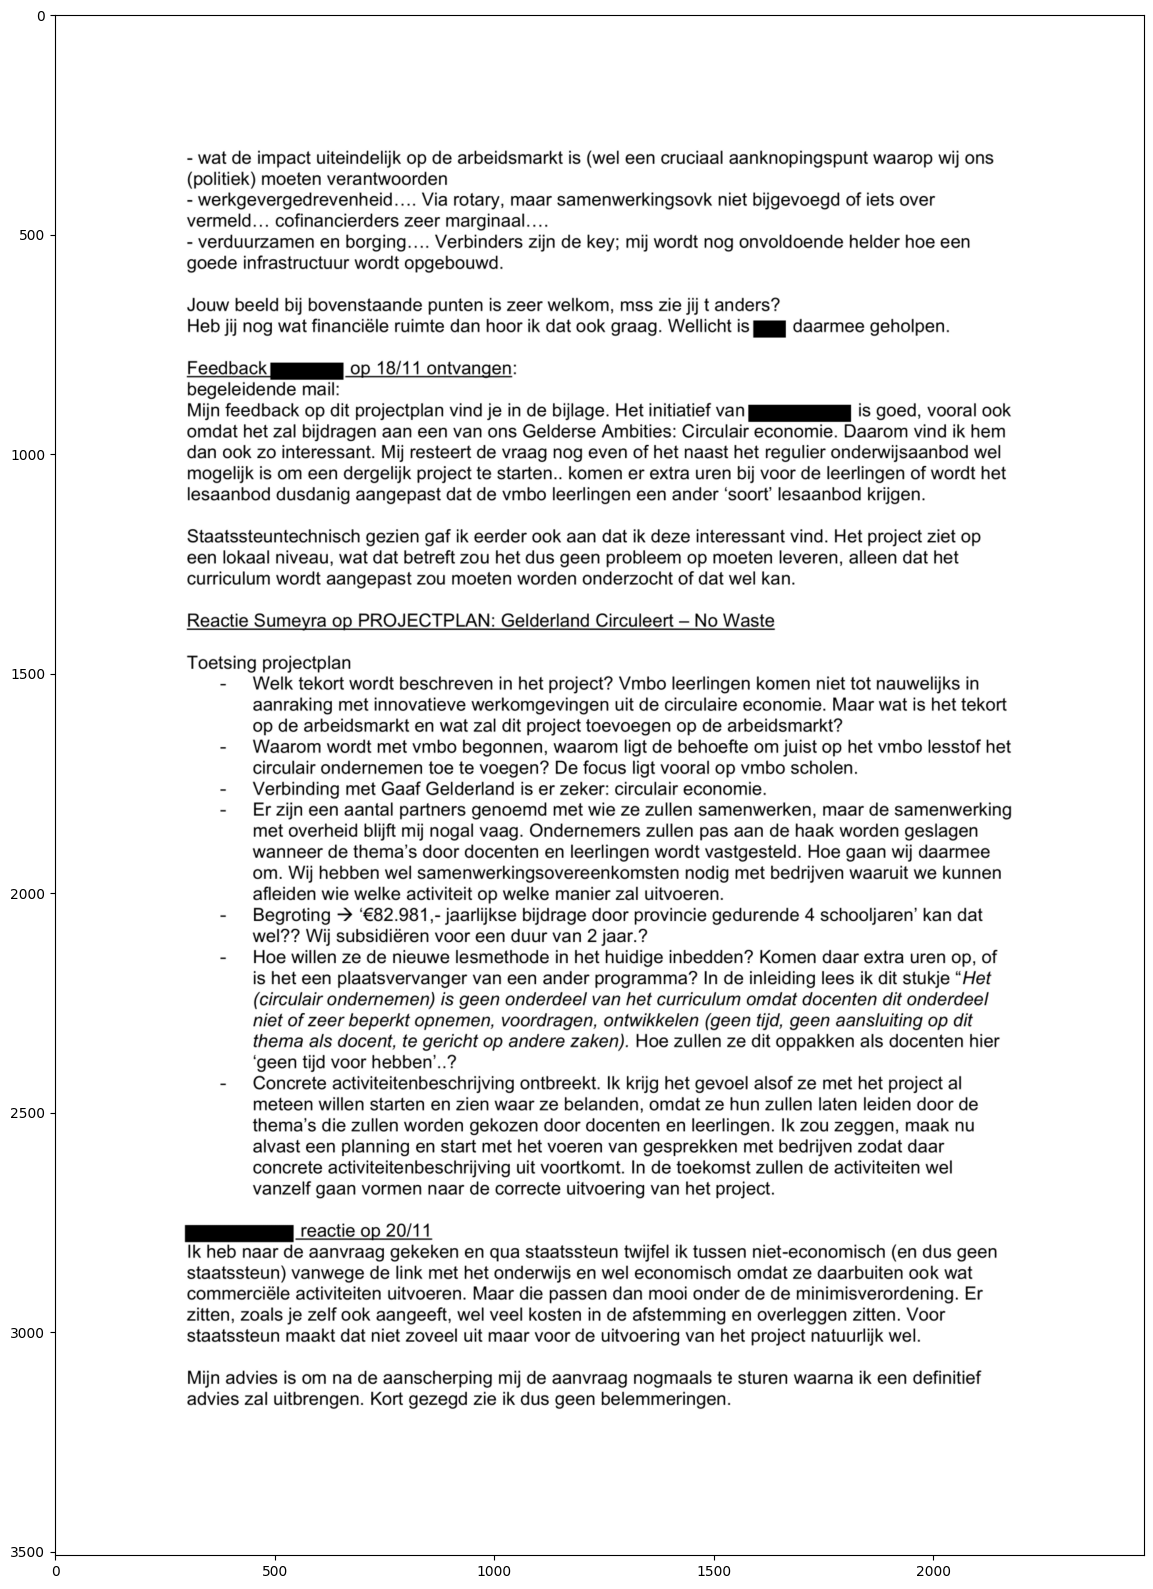

In [7]:
show_image(test_image_1)

THe above iamge contains a nice example of redactions that should be relatively easy to pick up with a single-line detection method, as they are right between other words. Let's build on this intuition and implement the first part of the algorithm.

<a id="tesseract"><h2>Analysing Tesseract output</h2></a>

We will start by getting the information about characters from Tesseract, and experiment with the required confidence level for the text recognition to have as little as possible false positive redactions.

In [8]:
# get the tesseract data in a dict format and put it in a pandas dataframe
image_1_tesseract_df = pytesseract.image_to_data(test_image_1, lang='nld+eng', output_type=Output.DATAFRAME,
                                                config='-c preserve_interword_spaces=1')

We can also quickly run Tesseract and ask it to return a string, to nicely see the output.

In [9]:
print(pytesseract.image_to_string(test_image_1, lang='nld+eng', config='-c preserve_interword_spaces=1'))

- wat de impact uiteindelijk op de arbeidsmarkt is (wel een cruciaal aanknopingspunt waarop wij ons
(politiek) moeten verantwoorden

- werkgevergedrevenheid.... Via rotary, maar samenwerkingsovk niet bijgevoegd of iets over
vermeld... cofinancierders zeer marginaal....

- verduurzamen en borging.... Verbinders zijn de key; mij wordt nog onvoldoende helder hoe een
goede infrastructuur wordt opgebouwd.

Jouw beeld bij bovenstaande punten is zeer welkom, mss zie jij t anders?
Heb jij nog wat financiële ruimte dan hoor ik dat ook graag. Wellicht is Bj daarmee geholpen.

Feedback EN op 18/11 ontvangen:
begeleidende mail:

Mijn feedback op dit projectplan vind je in de bijlage. Het initiatief van BENN is goed, vooral ook
omdat het zal bijdragen aan een van ons Gelderse Ambities: Circulair economie. Daarom vind ik hem
dan ook zo interessant. Mij resteert de vraag nog even of het naast het regulier onderwijsaanbod wel
mogelijk is om een dergelijk project te starten. komen er extra uren bij voo

Although it is a bit tricky to see, there are several cases where the redacted text should have left spaces, but didnt, and instead procuded 'garbage' text, such as lots of sequential capital letters. We will now experiment a bit with the confidence return by Tesseract, to see if we can improve this.

In [10]:
def filter_tesseract_dataframe(dataframe: pd.DataFrame, tesseract_confidence: int=65)-> pd.DataFrame:
    """
    Function that takes the output of Pytesseract as return by the 'image_to_data' function
    with the Output.DATAFRAME option, and filters out words with too low a confidence, but leaves
    spaces and newlines intact (by also keeping values where the confidence is lower than 0)
    :dataframe: pandas dataframe as obtained from 'image_to_data'
    :tesseract_confidence: the minimum confidence threshold from Tesseract, below which words should be filtered out
    the value can range between 0 and 100.
    """
    assert 0 < tesseract_confidence < 100
    
    return dataframe[(dataframe['conf'] > tesseract_confidence) | (dataframe['conf'] < 0)]

First we will see haw many less words we have if we set the confidence treshold of Tesseract to 65.

In [11]:
filtered_df_image_1 = filter_tesseract_dataframe(image_1_tesseract_df)
print("By upping the confidence threshold in Tesseract we removed %d words" % (image_1_tesseract_df.shape[0] - filtered_df_image_1.shape[0]))


By upping the confidence threshold in Tesseract we removed 10 words


Let us now print the output of what we dropped.

In [12]:
pd.concat([image_1_tesseract_df, filter_tesseract_dataframe(image_1_tesseract_df)]).drop_duplicates(keep=False)

level  page_num  block_num  par_num  line_num  word_num  left   top  \
95       5         1          2        1         2        15  1589   692   
102      5         1          3        1         1         2   503   784   
125      5         1          4        1         1        14  1578   888   
173      5         1          4        1         4         8  1007  1029   
311      5         1          7        3         1         2   451  1651   
342      5         1          7        4         1         1   376  1764   
343      5         1          7        4         1         2   407  1742   
356      5         1          7        5         1         2   453  1794   
423      5         1          7        6         1         2   453  2034   
448      5         1          7        7         1         2   453  2130   

     width  height       conf       text  
95      75      43  64.239639         Bj  
102    136      51  41.569016         EN  
125    234      39  44.141121       BENN  
173    145      29  27.404907   starten.  
311    153      30  38.149986     Waarom  
342     13       3  45.477070          -  
343     28      47  12.731407         __  
356    110      39  49.372009     Erzijn  
423    173      39  39.968895  Begroting  
448     72      30  60.847389        Hoe

This is not too bad, we have actually dropped all inline redactions (Bj, EN and BENN) from the dataframe, so now the spaces between the remaining words should be larger. However, we have also dropped a few real words, which could be problematic for the precision of the algorithm, which we will investigate later.

<a id="inline_redactions"><h2>Part 1: Detection of Inline Redactions</h2></a>

The first component of the algorithm is the detection of inline redactions, such as the ones shown in the test image above. This is done by obtaining the output from Tesseract, thresholding it to remove false positive text, and detecting gaps between words that are at leas twice the size of a regular space. Finally ,the detected redactions are tresholded to remove false positives that are mostly white pieces of text.

In [13]:
# Function to check the percentage of non-white pixels in a possible redaction.
def redaction_color_threshold(text_image: np.ndarray, redaction: list, threshold: int = 50) -> bool :
    """
    Function that takes a predicted redaction 'redaction' and checks whether or not enough pixels of the 
    images are another color than white.
    :text_image: numpy array of shape (H, W, 3) of which the color distribution should be checked.
    :redaction: list with coordinates of the annotation, where the redaction is a list of 4 tuples with 4 coordinates
    (topleft, topright, bottomright, bottomleft).
    """
    
    assert len(redaction) == 4
    assert len(text_image.shape) == 3
    assert text_image.shape[-1] == 3

    top, left, bottom, right = redaction[0][1], redaction[0][0], redaction[-2][1], redaction[-2][0]
    
    # get the pixels belonging to the redaction
    redaction_patch = text_image[top:bottom, left:right, :]
    total_size = redaction_patch.shape[0] * redaction_patch.shape[1]
    # use 700 so that we allow for some small variations in the scans
    white_pixels = (redaction_patch.sum(axis=-1) > 700).sum()
    
    return (1-(white_pixels / total_size)) * 100 > threshold

For the one line redactions we simply calculate the number of pixels between two words that are on the same line and have a high enough confidence score in tesseract. If the confidence is too low, that word will be completely skipped and the next word will be used for the comparison (this might then indicate a redaction). We could also try to increase the performance by filtering the codes often present in the text, but for the aforementioned reason this would not make a difference, as this would result in more white pixels, and this fail the threshold for the constraint anyway.

In [14]:
def one_line_detection(text_image: np.ndarray, tesseract_confidence: int = 65, space_size: int = 15,
                      detect_start_redactions: bool=True) -> int:
    """
    Complete algorithm for the detection of one-line redactions in scanned-in document by using Tesseract and some
    heuristics on the word structure.
    :text_mage: numpy array of the shape (H, W, 3)
    :tesseract_confidence: minimal confidence for tesseract to keep the word in the output
    :space_size: integer specifying the typical size of a space.
    :detect_start_redaction: boolean specifying whether or not the heuristic to detect starting redactions
    should be used.
    """

    assert len(text_image.shape) == 3
    assert text_image.shape[-1] == 3

    assert 0 < tesseract_confidence < 100
    
    # run tesseract to get the locations of the words
    tesseract_df = pytesseract.image_to_data(text_image, lang='nld+eng', output_type=Output.DATAFRAME)

    # Filter on confidence, also remove NaN characters (confidence of -1)
    # as we are only interested in interword distance
    filtered_tesseract_df = tesseract_df[tesseract_df['conf'] > tesseract_confidence]
    # Add right and bottom coordinates for ease
    filtered_tesseract_df.loc[:, 'right'] = filtered_tesseract_df['left']+filtered_tesseract_df['width']
    filtered_tesseract_df.loc[:, 'bottom'] = filtered_tesseract_df['top']+filtered_tesseract_df['height']
    
    # Get the first words of all sentences to detect the border case where a line starts 
    # a redactions
    first_words = filtered_tesseract_df.groupby(['block_num', 'par_num', 'line_num']).first()
    min_first_word = first_words['left'].min()
    possible_redactions = []
    
    for _, sentence_df in filtered_tesseract_df.groupby(['block_num', 'par_num', 'line_num']):
        # check first word, and whether or not the distance between the second word and the start of the average line 
        # is long enough
        if detect_start_redactions:
            first_word = sentence_df.iloc[0]
            # check if the horizontal distance between the words is big enough
            if((first_word['left'] - min_first_word) > (space_size*2)):
                # define coordinates as a tuple of length four width 4 coordinates: (topleft, topright, bottomright, bottomleft)
                coordinates = [[min_first_word, first_word['top']], [first_word['left'], first_word['top']], 
                               [first_word['left'], first_word['bottom']], [min_first_word, first_word['bottom']]]
                # Check whether the color treshold is met
                if redaction_color_threshold(text_image, coordinates):
                    possible_redactions.append(coordinates)
            
        # Now we loop through the rest of the words
        for i in range(1, len(sentence_df)):
            # get the word en previous word in the sentence
            word = sentence_df.iloc[i]
            prev_word = sentence_df.iloc[i-1]
            # get the horizontal distance between the two words
            word_distance = word['left'] - prev_word['right']
            if word_distance > (2*space_size):
                coordinates = [[prev_word['right'], word['top']], [word['left'], word['top']], 
                               [word['left'], word['bottom']], [prev_word['right'], word['bottom']]]
                if redaction_color_threshold(text_image, coordinates):
                    possible_redactions.append(coordinates)
            # now we check the color constraint

    return possible_redactions

The above algorithm contains an additional heuristic in the form of the `detect_start_redactions`, which attempts to also detect starting heuristics by checking the position of the first word in a sentence to the average starting position of all sentences in the document. Note that although this could increase the amount of false positives (such as indentation), the color contraint threshold will remove these from the list of redactions again.

# Visualize the one-line redactions

Next we will visualize the redactions of the sample images to see of the first step of the algorithm works.

In [15]:
def visualize_redactions(image, redactions, tesseract_confidence: int = 65, space_size: int = 15):
    
    # create a copy of the image that we're
    # going to draw the redactions on
    final_image = image.copy()
    
    # function to convert all coordinates to integers
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    
    # find the debug redactions that skip the last check, make these red
    for redaction in redactions: cv2.polylines(final_image, [int_coords(redaction)], True, color=(0, 0, 255), thickness=5)
    # show the image
    show_image(final_image)

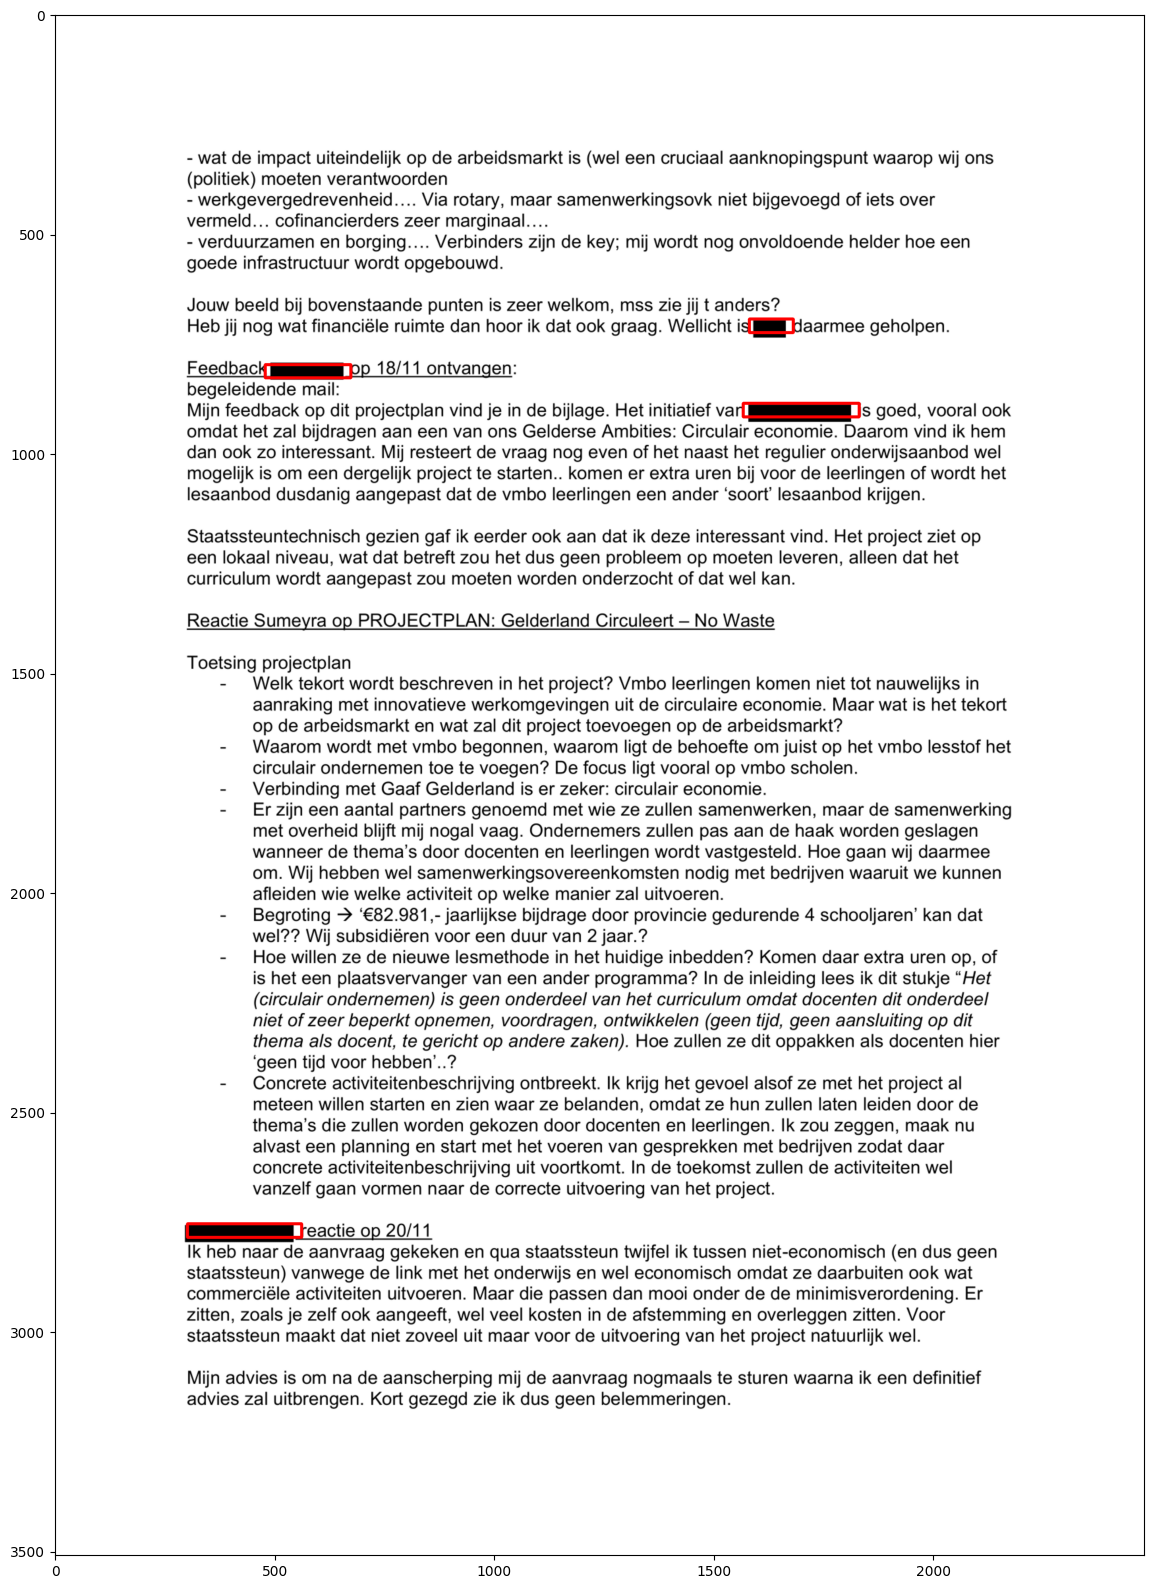

In [16]:
# see how the one-line redaction method
# works on the test image
visualize_redactions(test_image_1, one_line_detection(test_image_1), 65, 15)

For this document the detection works rather well, although the first issues can be seen: we cannot detect redactions that are it the start of sentences. We could maybe try something with the average starting position of a line, which we will also do with the `detect_start_redactions` parameter. Note that we can do some sort of heuristic for the start lines, but that is is more tricky for the end lines, as the end of a sentence is much more varied.

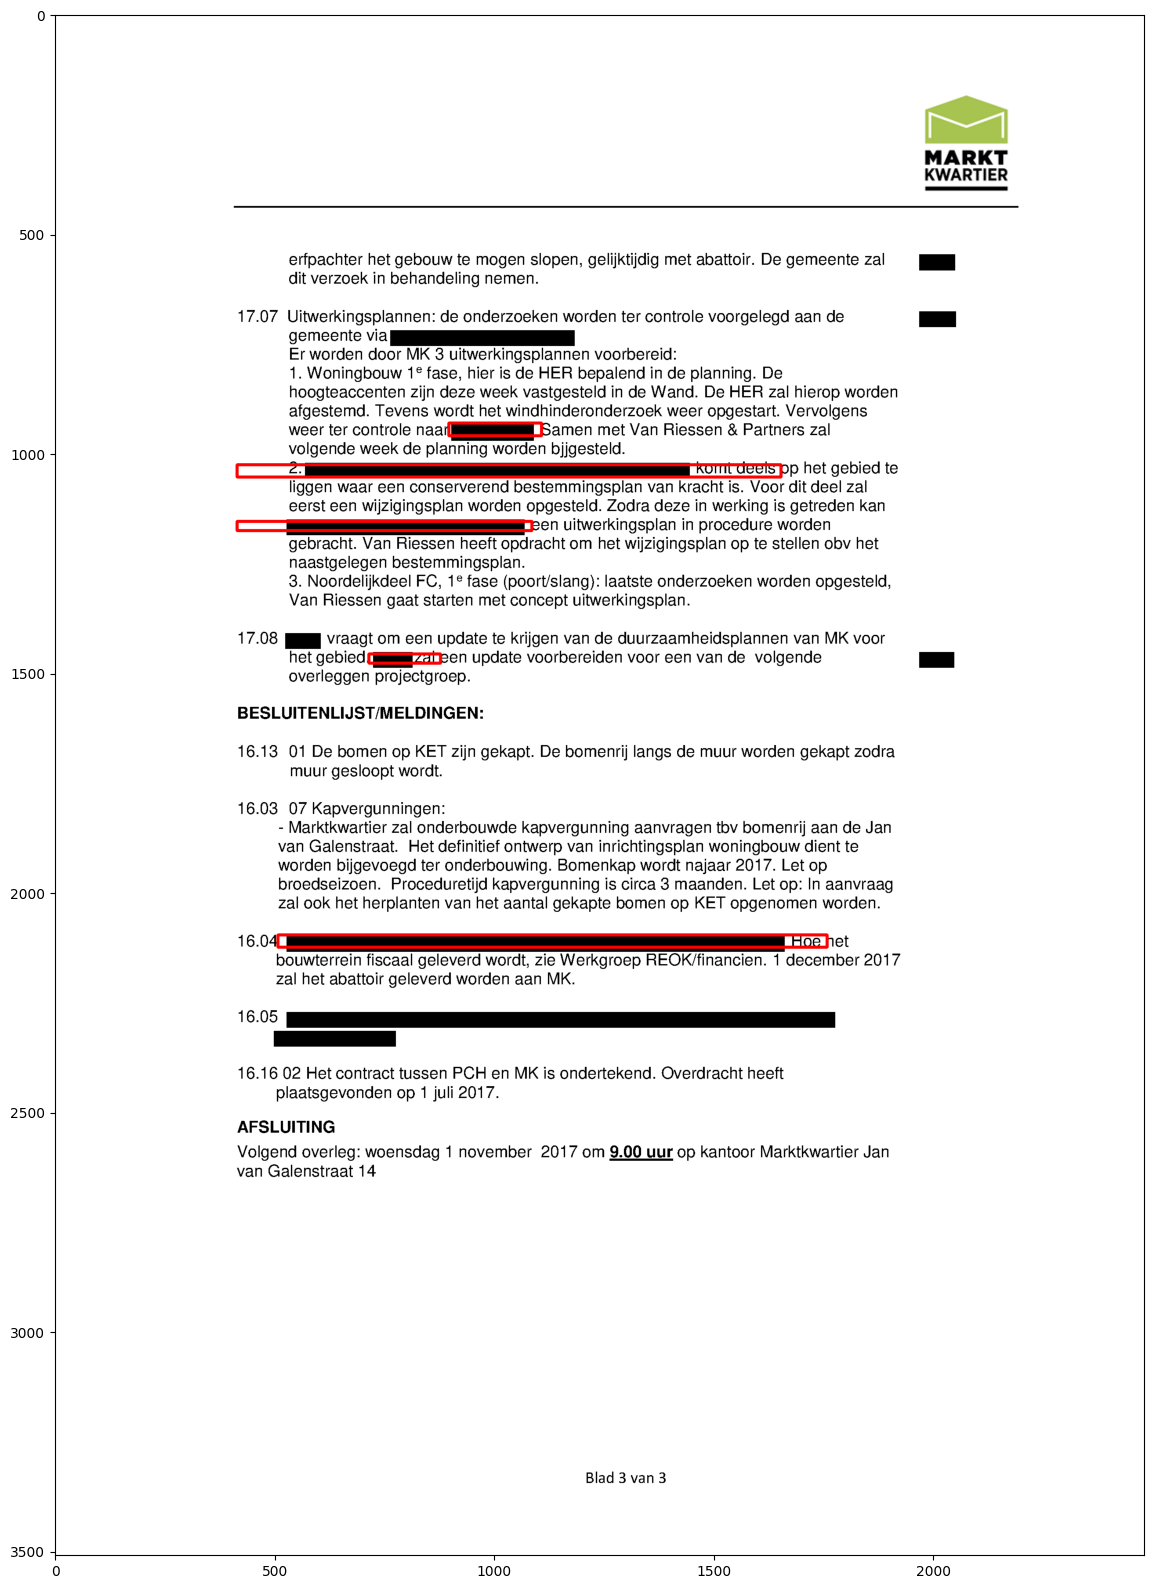

In [17]:
# another test
img_path = os.path.join('../resources/dataset/test/images', '5_20171011_verslag_-_projectgroep_gemeente_fca_17_07_geanonimiseerd-3.png')
img = load_image(img_path)
visualize_redactions(img, one_line_detection(img), 65, 15)

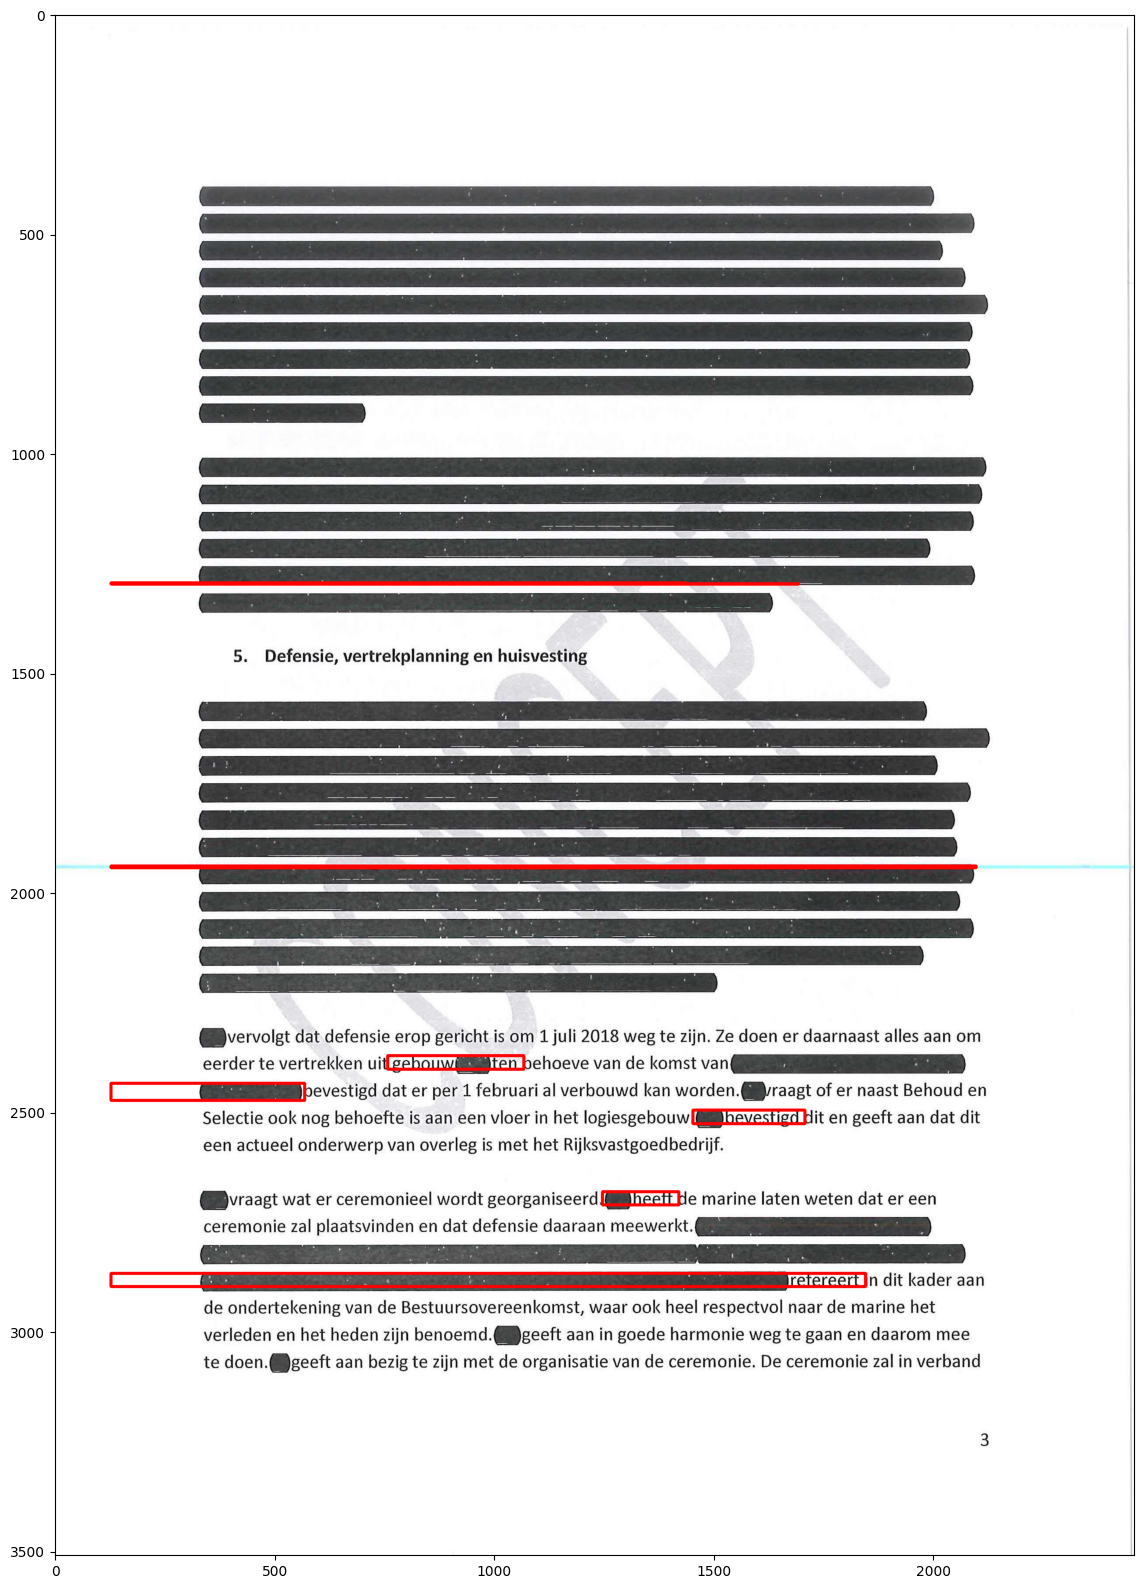

In [18]:
# let's also see how it works for the document
# that we have for the multi-line method
visualize_redactions(test_image_2, one_line_detection(test_image_2), 65, 10)

The above pages show that although the algorithm is able of picking up on some of the redactions in the documents, there are quite a few redactions that are missed, either because they are too small, are because they appear separate of other text,m making it difficult for the single line redaction method to pick them up.

We will now run a small analysis, seeing how many redactions we can find in the test set, purely in terms of the number of redaction, the actual PQ scores will be calculated later.

In [21]:
from pycocotools.coco import COCO
total_redactions = total_gold_standard_redactions = 0

total_redactions = 0
total_gold_standard_redactions = 0

directory = '../resources/dataset/test/images'
gold_standard = COCO('../resources/dataset/test/classic_test.json')
# # iterate over all images in our dataset
for img_id in tqdm(gold_standard.getImgIds()):
    filename = gold_standard.loadImgs(img_id)[0]['file_name']
    annotations = gold_standard.getAnnIds(img_id)
    # load the image
    
    image_path = os.path.join(directory, filename)
    image = load_image(image_path)
  
    # add the one line redactions of this image to the total count
    total_redactions += len(one_line_detection(image))
                          
    # add the number of regions in the gold standard for this file
    total_gold_standard_redactions += len(annotations)

print("We have detected %d redactions out of the total of %d" % (total_redactions, total_gold_standard_redactions))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


  1%|▎                                          | 2/284 [00:06<15:48,  3.37s/it]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fdead1f78b0>>
Traceback (most recent call last):
  File "/Users/rubenvanheusden/anaconda3/envs/NeuralRedactedTextDetection/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



Out of the 3586 redactions in the test set, we picked up roughly half a third of them, which is reasonable, however, some of our retrieved redactions might be false positives. We will now extend the algoritm to multiline redaction, and obtain SQ, RQ and PQ scores to be able to properly compare the algorithm to other methods.

<a id="multiline_redactions"><h2>Part 2: Incorporating Multine Line Redactions</h2></a>

Because a significant portion of our pages contain multiline redactions, we will have to develop a way to detect these as well. This is of course more tricky, as we will have to rely on large vertical spaces between lines, but we dont, really have any more information apart from that. We will show the approach and the issues, and propose a few adjustements that can still be made.

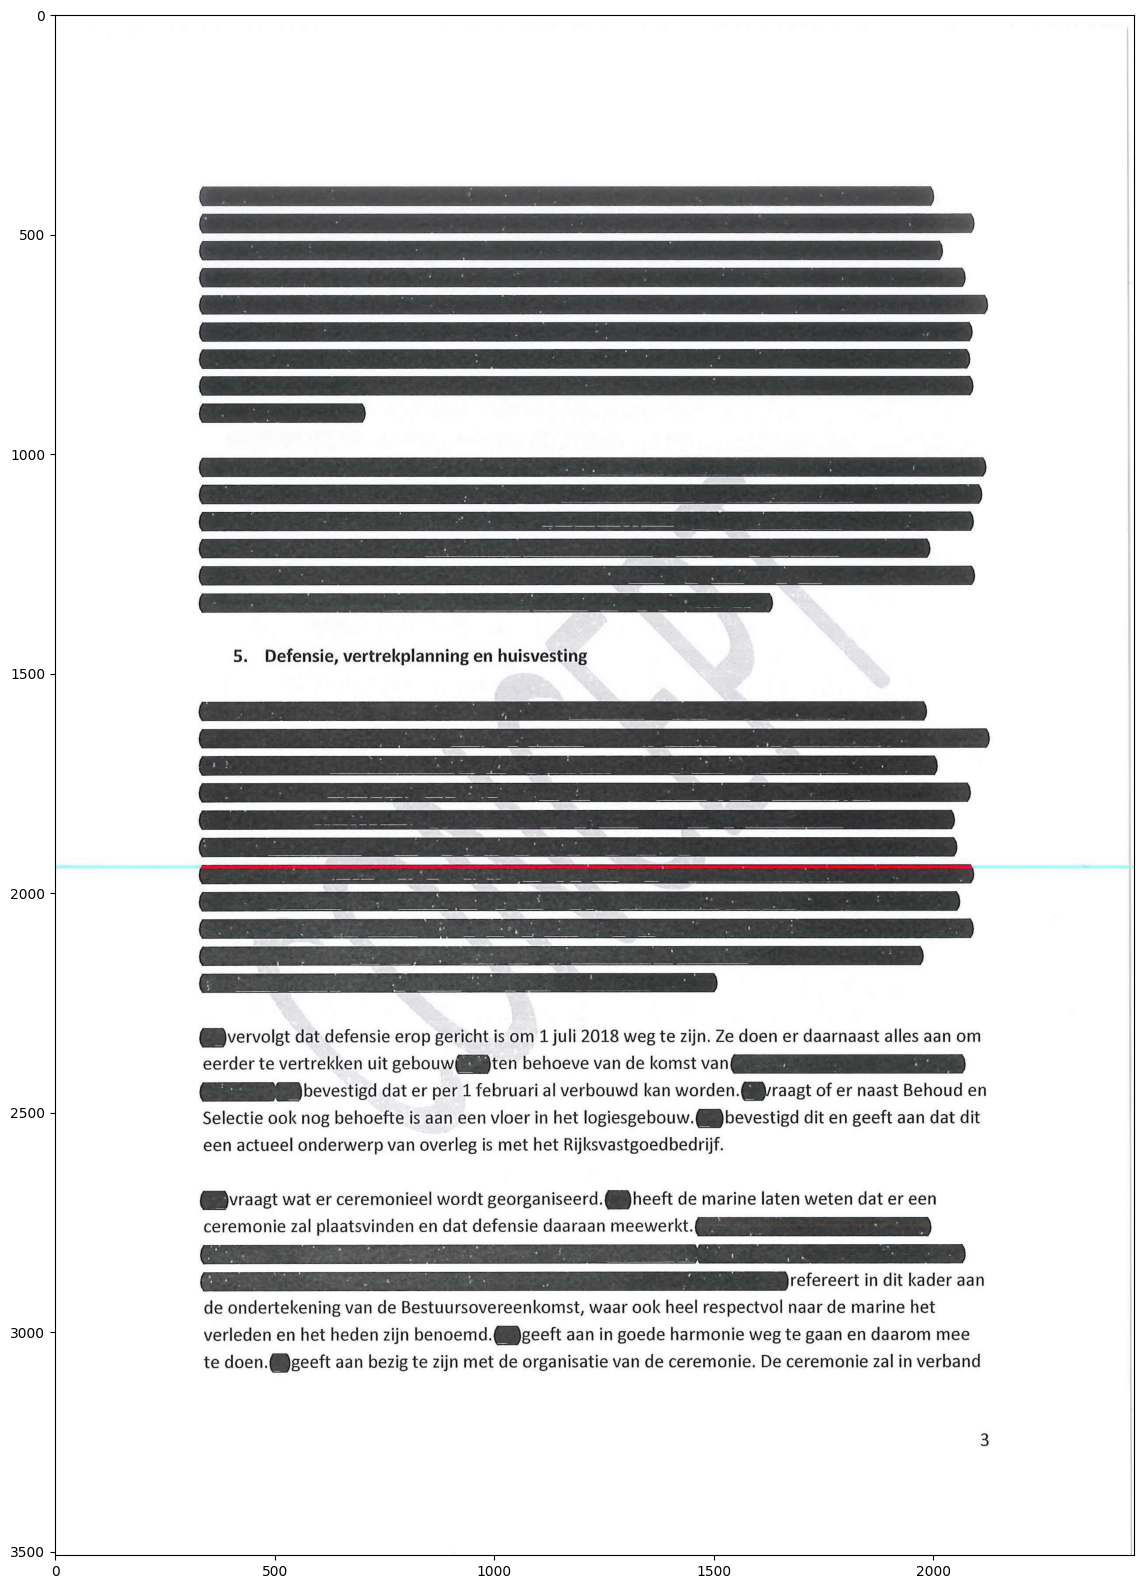

In [22]:
# show a typical multine redaction problem
show_image(test_image_2)

The main addition of the algorithm when compared to the single line variant is that we include the vertical distance between sentence as an indication of redacted test. We will then also use a bit more logic to include lines that are only partially redacted. 

In [23]:
def multi_line_detection(text_image: np.ndarray, tesseract_confidence: int = 65) -> int :
    """
    Complete algorithm for the detection of one-line redactions in scanned-in document by using Tesseract and some
    heuristics on the word structure.
    :text_mage: numpy array of the shape (H, W, 3)
    :tesseract_confidence: minimal confidence for tesseract to keep the word in the output
    """
    # run tesseract to get the locations of the words
    tesseract_df = pytesseract.image_to_data(text_image, lang='nld+eng', output_type=Output.DATAFRAME)
    
    filtered_tesseract_df = tesseract_df[tesseract_df['conf'] > tesseract_confidence]
    # Add right and bottom coordinates for ease
    filtered_tesseract_df.loc[:, 'right'] = filtered_tesseract_df['left']+filtered_tesseract_df['width']
    filtered_tesseract_df.loc[:, 'bottom'] = filtered_tesseract_df['top']+filtered_tesseract_df['height']
    
    # get the image height
    image_height = text_image.shape[0]
    
    # Get the height of the text
    height = np.array(filtered_tesseract_df['height'])
    
    # get the median height of the text, we will use this to calculate
    # how much of the page is occupied by words
    median_text_height = np.median(height[height < 0.3 * image_height])

    possible_redactions = []
    
    # get the boundaries for all of the sentences
    sentences = filtered_tesseract_df.groupby(['block_num', 'par_num', 'line_num'])
    sentences_left = sentences['left'].min()
    sentences_right = sentences['right'].max()
    sentences_top = sentences['top'].min()
    sentences_bottom = sentences['bottom'].max()
    
    # loop through all sentence pairs
    selected_sentence_pairs = []
    for i in range(1, len(sentences)):
        # check the vertical spaces between senences
        # here we set a redactio to be at least 3 tiems the median text height to reduce 
        # the number of false positives
        if (sentences_top.iloc[i] - sentences_bottom.iloc[i-1]) > 3*median_text_height:
            left_side = min(sentences_left.iloc[i-1], sentences_left.iloc[i])
            right_side = max(sentences_right.iloc[i-1], sentences_right.iloc[i])
            topleft = [left_side, sentences_bottom.iloc[i-1]]
            topright = [right_side, sentences_bottom.iloc[i-1]]
            bottomleft = [left_side, sentences_top.iloc[i]]
            bottomright = [right_side, sentences_top.iloc[i]]
            coordinates = [topleft, topright, bottomright, bottomleft]
    
            # Check the color constraint for the reactions
            if redaction_color_threshold(text_image, coordinates):
                possible_redactions.append(coordinates)

    return possible_redactions

    
    

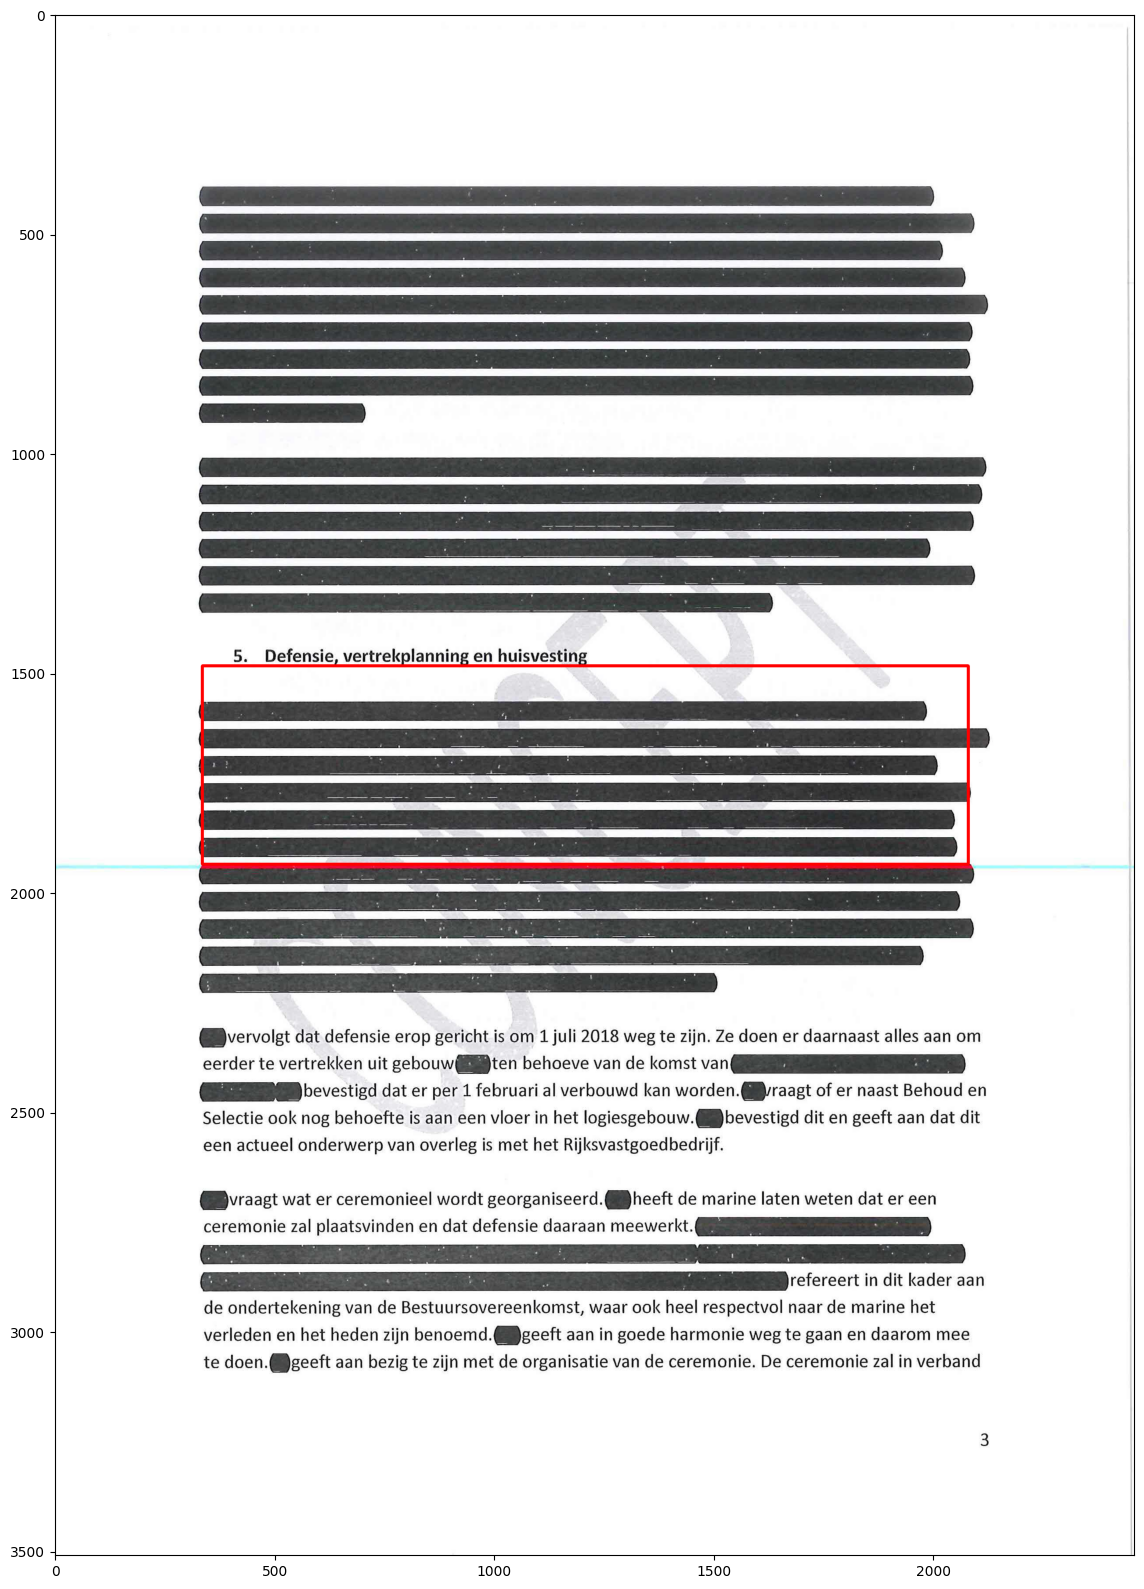

In [24]:
visualize_redactions(test_image_2, multi_line_detection(test_image_2))

Finally, we will combine both the inline an multiline redaction steps, so that we can evaluate the complete algorithm on the testset.

In [25]:
def combined_single_and_multiline_detection(text_image, tesseract_confidence: int = 65, space_size: int=15,
                                           detect_start_redactions: bool=True):
    # run tesseract to get the locations of the words
    tesseract_df = pytesseract.image_to_data(text_image, lang='nld+eng', output_type=Output.DATAFRAME)

    # Filter on confidence, also remove NaN characters (confidence of -1)
    # as we are only interested in interword distance
    filtered_tesseract_df = tesseract_df[tesseract_df['conf'] > tesseract_confidence]
    # Add right and bottom coordinates for ease
    filtered_tesseract_df.loc[:, 'right'] = filtered_tesseract_df['left']+filtered_tesseract_df['width']
    filtered_tesseract_df.loc[:, 'bottom'] = filtered_tesseract_df['top']+filtered_tesseract_df['height']
    first_words = filtered_tesseract_df.groupby(['block_num', 'par_num', 'line_num']).first()
    last_words = filtered_tesseract_df.groupby(['block_num', 'par_num', 'line_num']).last()
    min_first_word = first_words['left'].min()
    
    possible_redactions = []
    
    for _, sentence_df in filtered_tesseract_df.groupby(['block_num', 'par_num', 'line_num']):
        # check first word stuff
        if detect_start_redactions:
            first_word = sentence_df.iloc[0]
            if((first_word['left'] - min_first_word) > (space_size*2)):
                coordinates = [[min_first_word, first_word['top']], [first_word['left'], first_word['top']], 
                               [first_word['left'], first_word['bottom']], [min_first_word, first_word['bottom']]]
                if redaction_color_threshold(text_image, coordinates):
                    possible_redactions.append(coordinates)
            
        
        for i in range(1, len(sentence_df)):
           
            word = sentence_df.iloc[i]
            prev_word = sentence_df.iloc[i-1]
            word_distance = word['left'] - prev_word['right']
            if word_distance > (2*space_size):
                coordinates = [[prev_word['right'], word['top']], [word['left'], word['top']], 
                               [word['left'], word['bottom']], [prev_word['right'], word['bottom']]]
                if redaction_color_threshold(text_image, coordinates):
                    possible_redactions.append(coordinates)
            # now we check the color constraint

    # get the image height
    image_height = text_image.shape[0]
    
    # Get the height of the text
    height = np.array(filtered_tesseract_df['height'])
    
    # get the median height of the text, we will use this to calculate
    # how much of the page is occupied by words
    median_text_height = np.median(height[height < 0.3 * image_height])
    
    # get the boundaries for all of the sentences
    sentences = filtered_tesseract_df.groupby(['block_num', 'par_num', 'line_num'])
    sentences_left = sentences['left'].min()
    sentences_right = sentences['right'].max()
    sentences_top = sentences['top'].min()
    sentences_bottom = sentences['bottom'].max()

    for i in range(1, len(sentences)):
        if (sentences_top.iloc[i] - sentences_bottom.iloc[i-1]) > 2*median_text_height:
            left_side = min(sentences_left.iloc[i-1], sentences_left.iloc[i])
            right_side = max(sentences_right.iloc[i-1], sentences_right.iloc[i])
            topleft = [left_side, sentences_bottom.iloc[i-1]]
            topright = [right_side, sentences_bottom.iloc[i-1]]
            bottomleft = [left_side, sentences_top.iloc[i]]
            bottomright = [right_side, sentences_top.iloc[i]]
            coordinates = [topleft, topright, bottomright, bottomleft]
            if redaction_color_threshold(text_image, coordinates):
                possible_redactions.append(coordinates)
    
    return possible_redactions

Now we run this combined algorithm again on the above page, and see what happens.

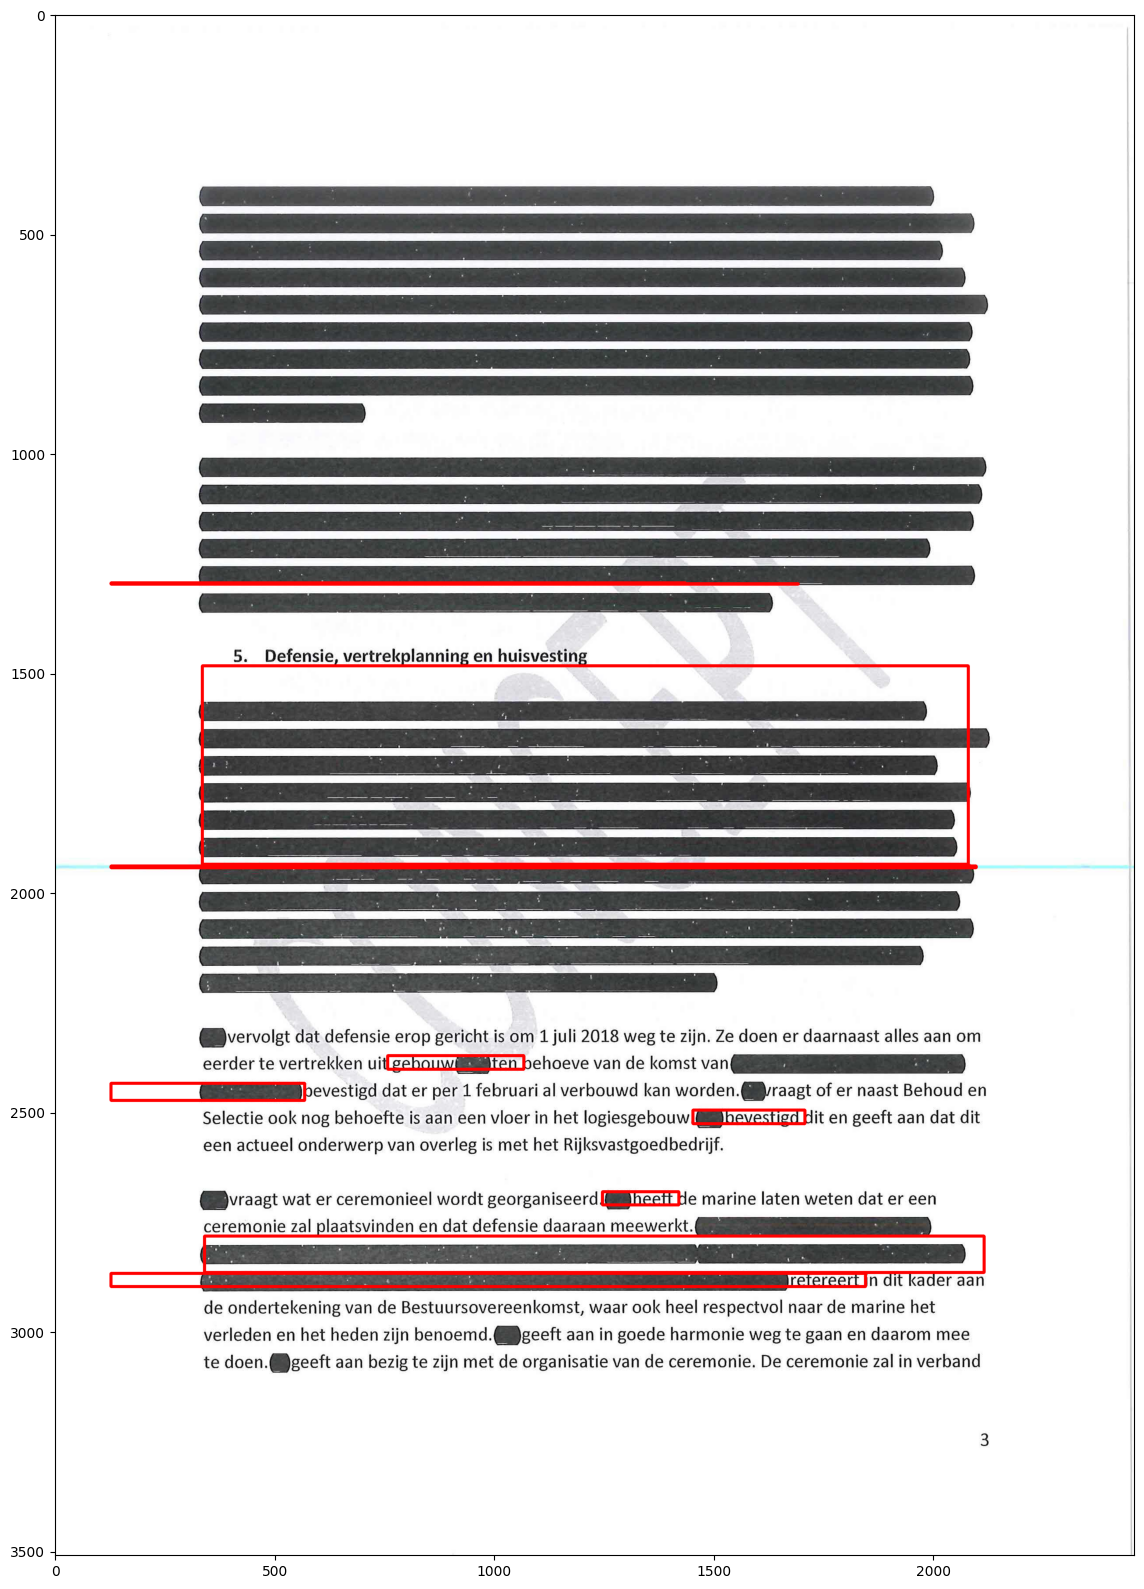

In [26]:
# adapt the space size threshold slightly
visualize_redactions(test_image_2, combined_single_and_multiline_detection(test_image_2), space_size=10)

This gives us a decent amount of detection, but we cannot really be sure until we calculate the PQ scores, which is what we will do next.

<a id="evaluation"><h2>Model Evaluation</h2></a>

To gain an accuratee estimate of performance of the model, we will be evaluating it using the panoptic quality metric, and print the RQ and SQ scores.

In [27]:
from evaluation import *
gold_standard = read_json('../resources/dataset/test/extended_test.json')

In [28]:
def flatten_coords(list_of_coords: list):
    out = []
    for coord in list_of_coords:
        out.extend(coord)
    return out

In [29]:
# rewrite this to just work with only the output polygons
from pycocotools.mask import frPyObjects, toBbox, area
def get_model_predictions(gold_standard_json):
    predicted_annotations = []

    for image in tqdm(gold_standard_json['images']):
        image_name = os.path.join('../resources/dataset/test/images', image['file_name'])
        predictions = combined_single_and_multiline_detection(load_image(image_name))
        
        for prediction in predictions:
            flattened_prediction = flatten_coords(prediction)
            lre_mask = frPyObjects([flattened_prediction], image['height'], image['width'])
            annot = {
                'bbox': toBbox(lre_mask),
                'area': area(lre_mask),
                'iscrowd': 0,
                'image_id': image['id'],
                'bbox_mode': 1,
                'segmentation': lre_mask[0]
            }
            predicted_annotations.append(annot)

    return predicted_annotations
    
        

In [99]:
model_output = get_model_predictions(gold_standard)

  0%|                                           | 1/439 [00:02<21:14,  2.91s/it]

KeyboardInterrupt



In [93]:
edact_ray_scores = evaluate_predictions(gold_standard['annotations'],
                                        model_output,
                                        do_filtering=True,
                                        iou_score=0.5, 
                                        confidence_score=None,
                                        count_empty_pages=True)

100%|███████████████████████████████████████████| 63/63 [00:15<00:00,  4.08it/s]


In [95]:
PQ_calculation(edact_ray_scores)

{'SQ': 0.651, 'F1': 0.113, 'P': 0.169, 'R': 0.085, 'PQ': 0.074}

In [98]:
calculate_color_specific_metrics(edact_ray_scores).T

/Users/rubenvanheusden/Desktop/IJDARKaj/notebooks/evaluation.py:122: RuntimeWarning: invalid value encountered in scalar divide
  R = dataframe['TP'].sum() / (dataframe['TP'].sum() + dataframe['FN'].sum())


SQ     F1      P      R     PQ
redaction_type                                   
black           0.623  0.146  0.288  0.098  0.091
border          0.577  0.006  0.032  0.003  0.003
color           0.685  0.303  0.530  0.212  0.208
gray            0.650  0.080  0.092  0.070  0.052
no_annotation   0.000  0.000  0.000    NaN  0.000
total           0.651  0.113  0.169  0.085  0.074